# Depth Pro Testing: Sharp Monocular Metric Depth
- Depth Pro: Sharp Monocular Metric Depth in Less Than a Second.: https://github.com/apple/ml-depth-pro
- Notebook:
- Notebook Contact:
  - michael.akridge@noaa.gov

# 0. Install Depth Pro


In [ ]:
# clone repo
!git clone https://github.com/apple/ml-depth-pro.git
# install
%cd /content/ml-depth-pro
!pip install .

# Download the model weights into the 'checkpoints' directory
!mkdir -p /content/ml-depth-pro/checkpoints
!wget https://ml-site.cdn-apple.com/models/depth-pro/depth_pro.pt -P checkpoints

# 1. Run on Single Image

In [ ]:
import torch
from PIL import Image
import depth_pro

# Check if a GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()

# Move model to the GPU
model = model.to(device)
model.eval()

# Set the image path (make sure the image is uploaded or available in the environment)
image_path = '/content/00028.jpg'

# Load and preprocess the image
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image)

# Move image to the GPU
image = image.to(device)

# Run inference
with torch.no_grad():  # Disable gradient calculation for inference
    prediction = model.infer(image, f_px=f_px)

# Extract depth in meters and focal length in pixels
depth = prediction["depth"].cpu()  # Move depth tensor back to CPU if necessary
focal_length_px = prediction["focallength_px"]  # Focal length stays on CPU

# Display results
print(f"Depth: {depth}")
print(f"Focal Length (px): {focal_length_px}")


Using device: cuda
Depth: tensor([[1.1760, 1.1517, 1.1297,  ..., 1.8562, 1.8589, 1.8783],
        [1.1322, 1.1213, 1.1129,  ..., 1.8424, 1.8481, 1.8443],
        [1.1116, 1.1062, 1.1026,  ..., 1.8374, 1.8407, 1.8489],
        ...,
        [1.9260, 1.9212, 1.9194,  ..., 1.7018, 1.7009, 1.6990],
        [1.9333, 1.9258, 1.9245,  ..., 1.7012, 1.6995, 1.6957],
        [1.9153, 1.9337, 1.9297,  ..., 1.6979, 1.6982, 1.7157]])
Focal Length (px): 1055.0758056640625


# 1a. Visualize Image

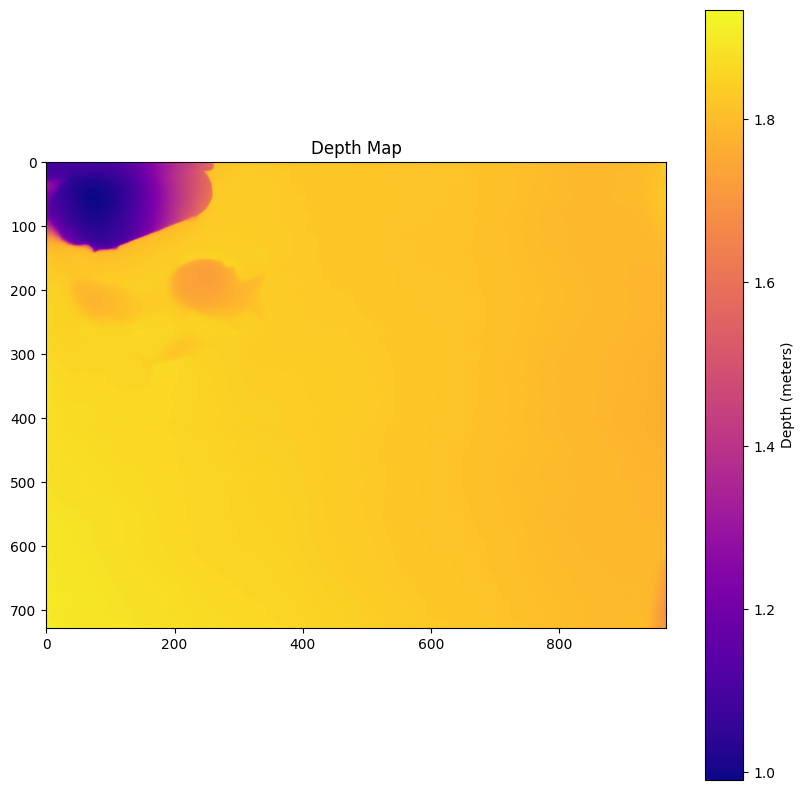

In [ ]:
import matplotlib.pyplot as plt
import torch

# Move the depth tensor back to CPU if necessary and convert to a NumPy array
depth_np = depth.squeeze().cpu().numpy()  # Remove any extra dimensions and move to CPU

# Display the depth map
plt.figure(figsize=(10, 10))
plt.imshow(depth_np, cmap='plasma')  # Use a color map like 'plasma' for better visualization
plt.colorbar(label='Depth (meters)')  # Add a colorbar to represent depth values
plt.title("Depth Map")
plt.show()


# 2. Run on Video - Setup
- Run install at top of notebook
- install for video processing

In [ ]:
# install for video processing
!pip install opencv-python
!apt-get install ffmpeg

# 2.a Extract Video Frames

In [ ]:
!mkdir frames  # Create a folder to store the frames
!ffmpeg -i /content/2024dvr_test_vid_clip_Trim.mp4 frames/frame_%04d.png  # Extract frames into 'frames' directory


# 2.b Run Model on Frames & Download Processed Video

In [ ]:
import torch
import cv2
import os
import numpy as np
from PIL import Image
import depth_pro
from google.colab import files

# Initialize the depth model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, transform = depth_pro.create_model_and_transforms()
model = model.to(device)
model.eval()

# Create an output folder for processed frames
os.makedirs('processed_frames', exist_ok=True)

# Folder where frames are stored
frame_folder = 'frames'

# Process each extracted frame
frame_files = sorted(os.listdir(frame_folder))
for frame_file in frame_files:
    frame_path = os.path.join(frame_folder, frame_file)

    # Load the frame
    frame = cv2.imread(frame_path)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_frame)

    # Preprocess and run inference
    pil_image = transform(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model.infer(pil_image)

    # Extract depth
    depth_map = prediction['depth'].squeeze().cpu().numpy()

    # Normalize depth map for visualization
    depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_map_normalized = np.uint8(depth_map_normalized)

    # Convert grayscale depth map to color
    depth_bgr = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_PLASMA)

    # Save the processed frame
    processed_frame_path = os.path.join('processed_frames', frame_file)
    cv2.imwrite(processed_frame_path, depth_bgr)

# Use ffmpeg to combine the frames into a video
!ffmpeg -framerate 24 -i processed_frames/frame_%04d.png -c:v libx264 -pix_fmt yuv420p output_video.mp4

# Download the output video
files.download('output_video.mp4')


# 3. (optional) Download Processed Frames

In [ ]:
import shutil
from google.colab import files

# Zip the 'processed_frames' directory
shutil.make_archive('processed_frames', 'zip', 'processed_frames')

# Download the zip file
files.download('processed_frames.zip')


# 4. (optional) Create Gif of Video

In [ ]:
!ffmpeg -i /content/output_video.mp4 -vf "scale=iw*0.75:ih*0.75" /content/output_video.gif
